In [1]:
import torch
from data_process import get_data_loaders, getFeatures
from lstm import Encoder, Decoder, Seq2Seq
from utils import plot_losses, plot_column

In [2]:
data, train_loader, val_loader, test_loader = get_data_loaders()
features = getFeatures()

[0.0041988  0.00420218 0.00420386 ... 0.41108662 0.41109065 0.41109251]


In [4]:
data

,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,route,max_altitude,min_altitude,mean_altitude,power,time_diff,current_atm,energy_atm,current_consumed,energy_consumed
0,1,0.00,0.005525,0.033426,0.763874,0.008701,0.002053,0.999960,0.715950,0.570210,...,0.4,0.25,0.25,0.25,0.010330,0.000000,0.002039,0.002267,0.003602,0.004199
1,1,0.20,0.005525,0.008357,0.764581,0.008869,0.002053,0.999960,0.715949,0.570205,...,0.4,0.25,0.25,0.25,0.010521,0.037879,0.002185,0.002432,0.003605,0.004202
2,1,0.30,0.005525,0.980501,0.764404,0.008869,0.002053,0.999960,0.715952,0.570205,...,0.4,0.25,0.25,0.25,0.010521,0.018939,0.002112,0.002349,0.003607,0.004204
3,1,0.50,0.005525,0.986072,0.764228,0.008869,0.002053,0.999960,0.715956,0.570213,...,0.4,0.25,0.25,0.25,0.010521,0.037879,0.002185,0.002432,0.003610,0.004207
4,1,0.60,0.005525,1.000000,0.762284,0.008534,0.002053,0.999960,0.715960,0.570213,...,0.4,0.25,0.25,0.25,0.010139,0.018939,0.002100,0.002336,0.003611,0.004209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257891,279,152.10,0.060773,0.551532,0.571226,0.008869,0.002048,0.999984,0.721872,0.590608,...,0.6,1.00,0.25,0.50,0.010392,0.018939,0.002112,0.002345,0.422761,0.411081
257892,279,152.20,0.060773,0.545961,0.569813,0.008869,0.002048,0.999984,0.721904,0.590608,...,0.6,1.00,0.25,0.50,0.010391,0.018939,0.002112,0.002345,0.422762,0.411083
257893,279,152.41,0.066298,0.526462,0.571050,0.009203,0.002048,0.999984,0.721937,0.590610,...,0.6,1.00,0.25,0.50,0.010751,0.039773,0.002218,0.002457,0.422766,0.411087
257894,279,152.60,0.060773,0.520891,0.570873,0.009538,0.002048,0.999984,0.721946,0.590619,...,0.6,1.00,0.25,0.50,0.011110,0.035985,0.002224,0.002464,0.422770,0.411091


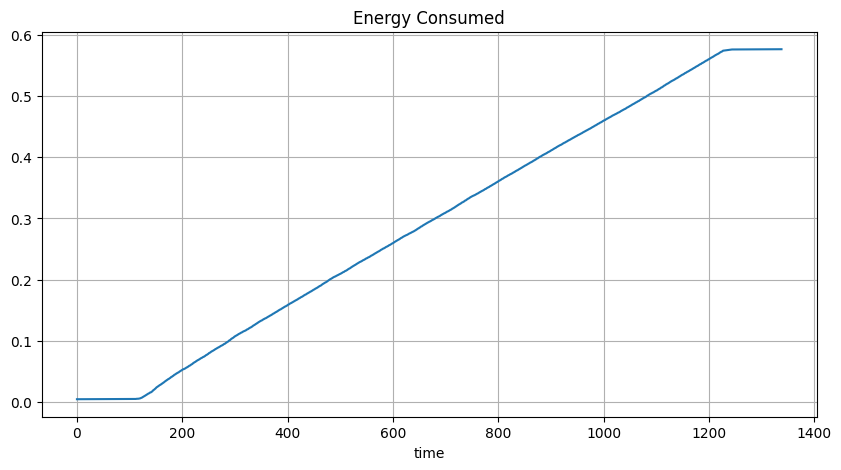

In [5]:
plot_column(data[data["flight"] == 1], "energy_consumed")

In [7]:
# Train model 
# Assuming the model is already defined as per your provided classes
from tqdm import tqdm

input_size = len(features)
hidden_size = 100  
num_layers = 3

encoder = Encoder(input_size, hidden_size, num_layers)
decoder = Decoder(1, hidden_size, num_layers)  # Decoder input size is 1 since we predict one step at a time
seq2seq_model = Seq2Seq(encoder, decoder)
output_seq_length = 2

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq_model.parameters(), lr=0.0001)

# Training loop with validation and early stopping
num_epochs = 10  # Example epochs
best_val_loss = float('inf')
early_stopping_patience = 3  # Number of epochs to wait after last time validation loss improved.
early_stopping_counter = 0  # Counter for early stopping

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq_model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        optimizer.zero_grad()
        outputs = seq2seq_model(inputs)  # No need for target length
        # Adjust the dimensions if necessary, based on your loss function requirements
        # Example: If your outputs and targets are both [batch_size, 2, 1]
        outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
        targets = targets[:, :output_seq_length]  # Ensuring targets are of the correct length

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.4f}")

    # Validation phase
    seq2seq_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
        for inputs, targets in progress_bar:
            outputs = seq2seq_model(inputs)  # No need for target length
            # Adjust dimensions as in the training phase
            outputs = outputs.squeeze(-1)
            targets = targets[:, :output_seq_length]

            loss = criterion(outputs, targets)

            total_val_loss += loss.item()
            progress_bar.set_postfix({'val_loss': loss.item()})

    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.4f}")

    # Check for early stopping
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        torch.save(seq2seq_model.state_dict(), 'best_model.pth')
        print("Saved the new best model.")
        early_stopping_counter = 0  # reset counter if validation loss improves
    else:
        early_stopping_counter += 1
        print(f"Validation loss did not improve. Counter {early_stopping_counter}/{early_stopping_patience}")
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break  # Stop training


Epoch 1/10 [TRAIN]: 100%|██████████| 2418/2418 [00:23<00:00, 102.27it/s, train_loss=8.18e-5] 


Epoch 1/10, Average Training Loss: 0.0083


Epoch 1/10 [VAL]: 100%|██████████| 806/806 [00:03<00:00, 239.61it/s, val_loss=6.87e-5] 


Epoch 1/10, Average Validation Loss: 0.0005
Saved the new best model.


Epoch 2/10 [TRAIN]: 100%|██████████| 2418/2418 [00:20<00:00, 116.05it/s, train_loss=3.39e-5] 


Epoch 2/10, Average Training Loss: 0.0005


Epoch 2/10 [VAL]: 100%|██████████| 806/806 [00:02<00:00, 272.76it/s, val_loss=4.76e-5] 


Epoch 2/10, Average Validation Loss: 0.0005
Saved the new best model.


Epoch 3/10 [TRAIN]: 100%|██████████| 2418/2418 [00:21<00:00, 114.53it/s, train_loss=2.07e-5] 


Epoch 3/10, Average Training Loss: 0.0005


Epoch 3/10 [VAL]: 100%|██████████| 806/806 [00:02<00:00, 286.15it/s, val_loss=2.66e-5] 


Epoch 3/10, Average Validation Loss: 0.0004
Saved the new best model.


Epoch 4/10 [TRAIN]: 100%|██████████| 2418/2418 [00:21<00:00, 114.05it/s, train_loss=1.4e-5]  


Epoch 4/10, Average Training Loss: 0.0005


Epoch 4/10 [VAL]: 100%|██████████| 806/806 [00:03<00:00, 249.25it/s, val_loss=2.08e-5] 


Epoch 4/10, Average Validation Loss: 0.0004
Saved the new best model.


Epoch 5/10 [TRAIN]: 100%|██████████| 2418/2418 [00:21<00:00, 112.80it/s, train_loss=3.48e-5] 


Epoch 5/10, Average Training Loss: 0.0004


Epoch 5/10 [VAL]: 100%|██████████| 806/806 [00:02<00:00, 281.70it/s, val_loss=9.5e-5]  


Epoch 5/10, Average Validation Loss: 0.0005
Validation loss did not improve. Counter 1/3


Epoch 6/10 [TRAIN]: 100%|██████████| 2418/2418 [00:21<00:00, 114.28it/s, train_loss=8.3e-6]  


Epoch 6/10, Average Training Loss: 0.0004


Epoch 6/10 [VAL]: 100%|██████████| 806/806 [00:03<00:00, 257.57it/s, val_loss=1.55e-5] 


Epoch 6/10, Average Validation Loss: 0.0004
Saved the new best model.


Epoch 7/10 [TRAIN]: 100%|██████████| 2418/2418 [00:20<00:00, 117.30it/s, train_loss=7.02e-6] 


Epoch 7/10, Average Training Loss: 0.0004


Epoch 7/10 [VAL]: 100%|██████████| 806/806 [00:02<00:00, 299.33it/s, val_loss=1.62e-5] 


Epoch 7/10, Average Validation Loss: 0.0004
Saved the new best model.


Epoch 8/10 [TRAIN]: 100%|██████████| 2418/2418 [00:20<00:00, 120.50it/s, train_loss=1.33e-5] 


Epoch 8/10, Average Training Loss: 0.0004


Epoch 8/10 [VAL]: 100%|██████████| 806/806 [00:02<00:00, 293.86it/s, val_loss=9.52e-6] 


Epoch 8/10, Average Validation Loss: 0.0004
Saved the new best model.


Epoch 9/10 [TRAIN]: 100%|██████████| 2418/2418 [00:19<00:00, 122.34it/s, train_loss=2.66e-5] 


Epoch 9/10, Average Training Loss: 0.0004


Epoch 9/10 [VAL]: 100%|██████████| 806/806 [00:02<00:00, 290.72it/s, val_loss=4.18e-5] 


Epoch 9/10, Average Validation Loss: 0.0004
Validation loss did not improve. Counter 1/3


Epoch 10/10 [TRAIN]: 100%|██████████| 2418/2418 [00:20<00:00, 120.34it/s, train_loss=2.32e-5] 


Epoch 10/10, Average Training Loss: 0.0004


Epoch 10/10 [VAL]: 100%|██████████| 806/806 [00:02<00:00, 288.10it/s, val_loss=2.43e-5] 

Epoch 10/10, Average Validation Loss: 0.0004
Validation loss did not improve. Counter 2/3


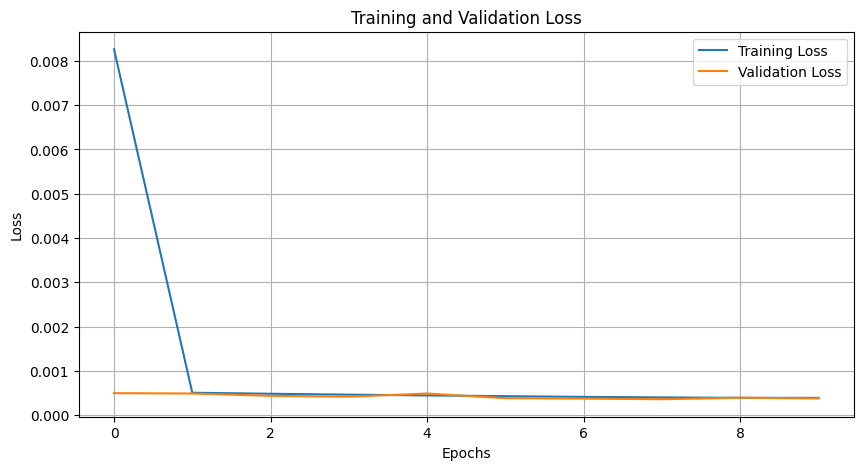

In [13]:
plot_losses(train_losses=train_losses, val_losses=val_losses)

In [8]:
# Load the best model
seq2seq_model.load_state_dict(torch.load('best_model.pth'))

# Test the model
seq2seq_model.eval()
with torch.no_grad():
    total_loss = 0
    for inputs, targets in test_loader:
        outputs = seq2seq_model(inputs)  # No need for target length
        # Adjust the dimensions if necessary, based on your loss function requirements
        # Example: If your outputs and targets are both [batch_size, 2, 1]
        outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
        targets = targets[:, :output_seq_length]  # Ensuring targets are of the correct length

        loss = criterion(outputs, targets)
        total_loss += loss.item()
    print(f"Average test loss: {total_loss / len(test_loader)}")

Average test loss: 0.00044739922954098574
